A Full Gap Up occurs when the opening price is greater than yesterday's high price. 
A Partial Gap Up occurs when today's opening price is higher than yesterday's close, but not higher than yesterday's high. 

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from math import sqrt
from sklearn.metrics import confusion_matrix

sns.set_style('white')

In [2]:
# read data
year = 2018
ticker = 'IFM'

col_names=['TIME', 'X', 'Y', 'Z'] 

df_2018 = pd.read_csv(os.path.join(f'../data/index/{year}/{ticker}.csv'), index_col=0, encoding='gbk')
df_2018.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open_interest']

df_2018.rename_axis("type", axis='index', inplace=True)

year = 2019

df_2019 = pd.read_csv(os.path.join(f'../data/index/{year}/{ticker}.csv'), index_col=0, encoding='gbk')
df_2019.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open_interest']

df_2019.rename_axis("type", axis='index', inplace=True)

year = 2020

df_2020 = pd.read_csv(os.path.join(f'../data/index/{year}/{ticker}.csv'), index_col=0, encoding='gbk')
df_2020.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open_interest']

df_2020.rename_axis("type", axis='index', inplace=True)


df = pd.concat([df_2018, df_2019, df_2020])
df['time'] = pd.to_datetime(df['time'])

df.reset_index(inplace=True)

# df = df.iloc[0:1000, :]
df

,type,code,time,open,high,low,close,volume,turnover,open_interest
0,SF,IF1801,2018-01-02 09:31:00,4051.6,4060.4,4051.6,4060.0,398.0,4.844222e+08,24365
1,SF,IF1801,2018-01-02 09:32:00,4060.0,4062.2,4058.6,4060.0,212.0,2.582576e+08,24241
2,SF,IF1801,2018-01-02 09:33:00,4059.8,4065.8,4059.8,4062.8,179.0,2.181614e+08,24118
3,SF,IF1801,2018-01-02 09:34:00,4062.6,4063.0,4060.0,4062.6,117.0,1.425521e+08,24049
4,SF,IF1801,2018-01-02 09:35:00,4062.8,4070.8,4062.4,4070.0,251.0,3.062792e+08,23926
...,...,...,...,...,...,...,...,...,...,...
175195,SF,IF2101,2020-12-31 14:56:00,5217.8,5218.4,5216.4,5217.8,468.0,7.325071e+08,89496
175196,SF,IF2101,2020-12-31 14:57:00,5217.8,5219.8,5216.6,5219.0,502.0,7.858570e+08,89727
175197,SF,IF2101,2020-12-31 14:58:00,5219.0,5219.0,5215.0,5218.2,704.0,1.101811e+09,90073
175198,SF,IF2101,2020-12-31 14:59:00,5218.2,5221.6,5216.8,5220.4,610.0,9.551740e+08,90469


In [3]:
# Extract the Daily Open and Close Value
df['date'] = df['time'].dt.date

df['date_before'] = df['date'].shift(1)
df['date_after'] = df['date'].shift(-1)

df["daily_open"] = (df["date_before"] != df["date"])
df["daily_close"] = (df["date_after"] != df["date"])

In [4]:
df_day = df.loc[ df["daily_open"] | df["daily_close"] ].copy()

df_day["yesterday_close"] = df_day["close"].shift(1, fill_value = 10000) 
df_day["today_close"] = df_day["close"].shift(-1)

df_day.drop(df_day.loc[df_day['daily_open'] == False].index, inplace=True)

df_day.set_index('date', inplace = True)

# Calculate Daily High
df_day["today_max"] = df.groupby(['date'], sort=False)['high'].max()

# Calculate Daily Low
df_day["today_min"] = df.groupby(['date'], sort=False)['low'].min()

irrelevant_col = ['date_before', 'date_after', 'volume', 'turnover', 'open_interest', 'type', 'code']
df_day.drop(columns=irrelevant_col, inplace = True)
df_day.head()

,time,open,high,low,close,daily_open,daily_close,yesterday_close,today_close,today_max,today_min
date,,,,,,,,,,,
2018-01-02,2018-01-02 09:31:00,4051.6,4060.4,4051.6,4060.0,True,False,10000.0,4104.0,4105.0,4051.6
2018-01-03,2018-01-03 09:31:00,4107.8,4108.0,4100.8,4102.2,True,False,4104.0,4121.6,4153.4,4097.2
2018-01-04,2018-01-04 09:31:00,4122.0,4128.0,4122.0,4123.2,True,False,4121.6,4135.8,4146.6,4115.8
2018-01-05,2018-01-05 09:31:00,4138.4,4139.8,4134.4,4135.8,True,False,4135.8,4148.2,4156.8,4125.2
2018-01-08,2018-01-08 09:31:00,4148.0,4153.0,4146.2,4149.2,True,False,4148.2,4163.8,4172.8,4135.2


When the open index is higher than the close index in the day before, we consider it as a "gap up". On the other hand, when the open index is lower than the close index in the day before, we consider it as a "gap down". 

We use the occurance of gap up to predict the closing price of the day. Here we analysis what the boundary for the gap will affect on the precision and recall of the algorithm starting from the close price of the day before (yesterday_close) to (yesterday_close * 1.01).

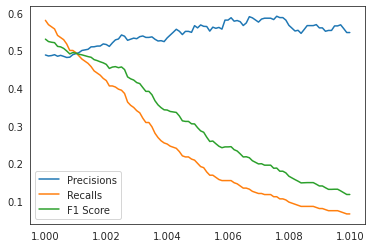

In [5]:
precisions = []
recalls = []
f1_scores = []

# X axis
x = np.arange(101)
x = 1 + x/10000

for i in range(101):
    boundary = 1 + i / 10000
    # print(boundary)
    df_day["gap_up"] = (df_day["open"] > df_day["yesterday_close"] * boundary)
    df_day["daily_up"] = (df_day["open"] < df_day["today_close"])
    
    
    # confusion matrix
    # (Not Gap Up / Not Daily Up) (Gap Up / Not Daily Up)
    # (Not Gap Up / Daily Up)     (Gap Up / Daily Up)
    cm = confusion_matrix(df_day["daily_up"], df_day["gap_up"])
    f1_scores.append(2 * cm[1, 1] / (2 * cm[1, 1] + cm[0, 1] + cm[1, 0]))
    
    if cm[1, 1] + cm[0, 1] == 0:
        precisions.append(1)
    else:
        precisions.append(cm[1, 1] / (cm[1, 1] + cm[0, 1]))
        
    if cm[1, 1] + cm[0, 1] == 0:
        recalls.append(1)
    else:
        recalls.append(cm[1, 1] / (cm[1, 1] + cm[1, 0]))
    
plt.plot(x, precisions, label='Precisions')
plt.plot(x, recalls, label='Recalls')
plt.plot(x, f1_scores, label='F1 Score')
plt.legend()
plt.show()

# print(df_day.loc[ df_day["gap_up"] & (df_day["daily_up"]) ].shape[0])

Here we chose 20 unit instead of percentage as the boundary of a gap. Here we calculate the daily high value minus the open price as the maximum profit we can get on that day, we also calculate the daily low value minus the open price as the maximum risk we on that day. We plot these two values in the graph below

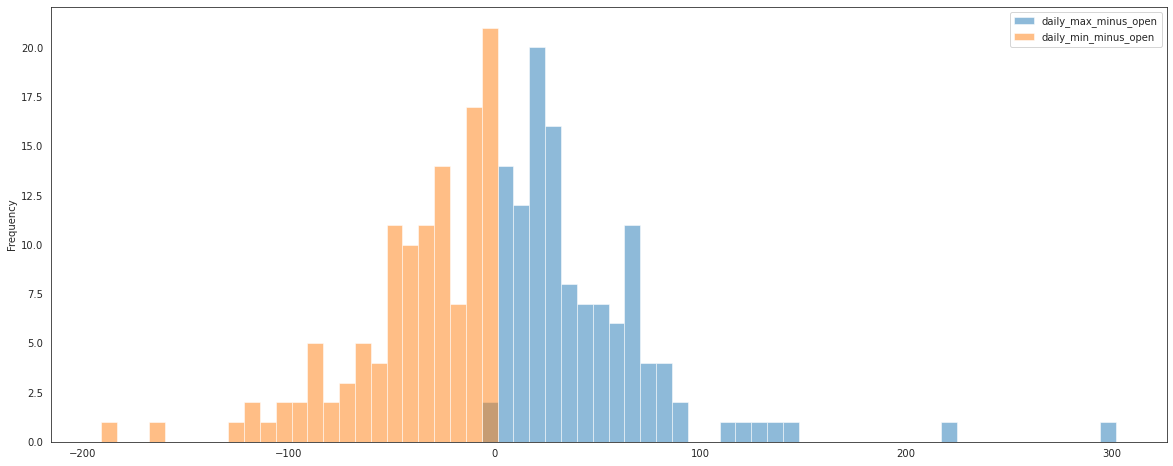

In [6]:
df_day["gap_up"] = (df_day["open"] > df_day["yesterday_close"] + 20)
df_day["gap_down"] = (df_day["open"] < df_day["yesterday_close"] - 20)

df_day["daily_max_minus_open"] = (df_day["today_max"] - df_day["open"])
df_day["daily_min_minus_open"] = (df_day["today_min"] - df_day["open"])

# Winsorsize Top Bottom
# q = df_day["daily_up_value"].quantile([0.05, 0.95])
# df_day["daily_up_value"].clip(lower=q.iloc[0], upper=q.iloc[1], inplace = True)

gap_up_count = df_day["gap_up"].value_counts()[1]
gap_down_count = df_day["gap_down"].value_counts()[1]

daily_max_min = df_day[df_day["gap_up"]][["daily_max_minus_open", "daily_min_minus_open"]].plot.hist(bins=64, alpha=0.5, figsize=(20, 8))

Then we calculate the difference between the maximum profit and the maximum risk on a specific day. It is calculated by (daily_max_minus_open + daily_min_minus_open), note the the first value is always non-negative and the second value is always non-positive, we call this "value_at_risk". Here we plot the distribution of "value_at_risk" when a gap up of 20 index unit occured. 

Mean： 5.054999999999999
STD： 64.87765324637064
Count： 120
Stardard Error: 5.922492360172578
Skewness： 0.7836978337615162
Kurtosis： 3.859584934292056


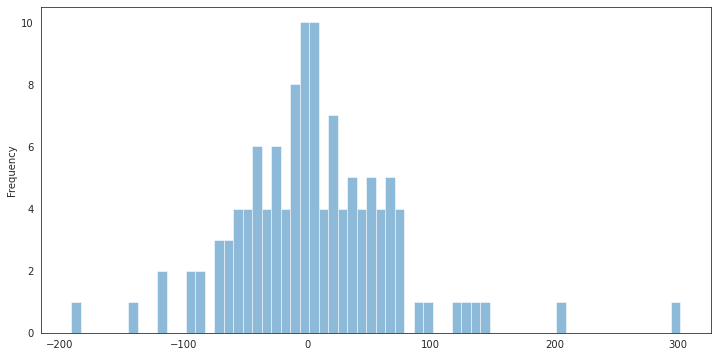

In [7]:
df_day["value_at_risk"] = df_day["daily_max_minus_open"] + df_day["daily_min_minus_open"]

print("Mean：", df_day[df_day["gap_up"]]["value_at_risk"].mean())

std = df_day[df_day["gap_up"]]["value_at_risk"].std()
print("STD：", std)
print("Count：", gap_up_count)
print("Stardard Error:", std / sqrt(gap_up_count))
print("Skewness：", df_day[df_day["gap_up"]]["value_at_risk"].skew())
print("Kurtosis：", df_day[df_day["gap_up"]]["value_at_risk"].kurtosis())

risk_gap_up = df_day[df_day["gap_up"]]["value_at_risk"].plot.hist(bins=64, alpha=0.5, figsize=(12, 6) )

Here we also plot the distribution of "value_at_risk" when a gap down of 20 index unit occured. 

Mean： -8.966666666666676
STD： 66.81213246242557
Count： 84
Stardard Error: 7.2898012940590835
Skewness： -0.678295135483116
Kurtosis： 1.1423784735260014


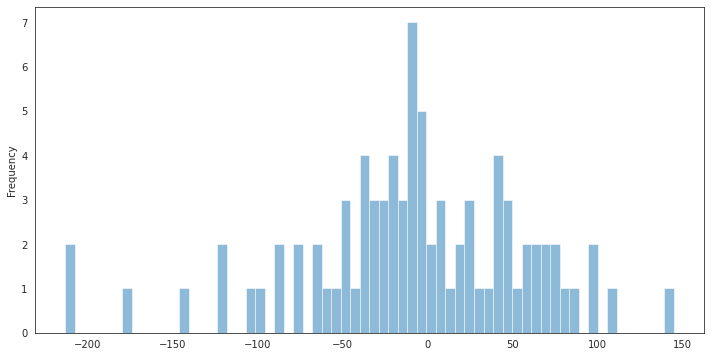

In [8]:
print("Mean：", df_day[df_day["gap_down"]]["value_at_risk"].mean())

std = df_day[df_day["gap_down"]]["value_at_risk"].std()
print("STD：", std)
print("Count：", gap_down_count)
print("Stardard Error:", std / sqrt(gap_down_count))
print("Skewness：", df_day[df_day["gap_down"]]["value_at_risk"].skew())
print("Kurtosis：", df_day[df_day["gap_down"]]["value_at_risk"].kurtosis())

risk_gap_down = df_day[df_day["gap_down"]]["value_at_risk"].plot.hist(bins=64, alpha=0.5, figsize=(12, 6) )